In [1]:
# Vanilla Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numba
import colorcet
# Custom Imports
from src.Calculators.ray_maker import ray_maker
from src.Optical_Depth.opacity_table import opacity
# from src.Luminosity.photosphere import get_photosphere
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [5 , 4]

In [2]:
#%% Constants & Converter
c_cgs = 3e10 # [cm/s]
Rsol_to_cm = 6.957e10 # [cm]

In [ ]:
def select_fix(m):
    if m == 4:
        snapshots = [233] #, 254, 263, 277 , 293, 308, 322]
        days = [1]# , 1.2, 1.3, 1.4, 1.56, 1.7, 1.8] 
    if m == 6:
        snapshots = [844]#, 881,  925, 950]
        days = [1]#, 1.1, 1.3, 1.4] # t/t_fb
    return snapshots, days

@numba.njit
def grad_calculator(rays, radii, sphere_radius = 15_000): 
    # Get the index of radius closest in sphere radius
    # diffs = np.abs(radii - sphere_radius)
    # idx = np.argmin(diffs)
    sphere_radius_cgs = sphere_radius * Rsol_to_cm
    for i, radius in enumerate(radii):
        if radius > sphere_radius_cgs:
            idx = i - 1 
            break
        
    step = radii[1] - radii[0]
    grad_E = np.zeros(len(rays))
    
    for i, ray in enumerate(rays):
        grad_E[i] = (ray[idx+1] - ray[idx]) / step 

    return grad_E, idx

def converger(rays, radii):
    
    grad_Es = []
    idxs = []
    for sphere_radius in radii:
        grad_E, idx = grad_calculator(rays, radii, sphere_radius)
        grad_Es.append(grad_E)
        idxs.append(idx)
        
    rel_error = [ 100 * (1 - (grad_Es[i]/grad_Es[i-1])) 
                 for i in range(1, len(grad_Es))]
    
    plt.figure( figsize = (16,4))
    plt.plot(radii[1::10], rel_error[::10], '-o', c='k')
    plt.xlabel('Sphere Radii')
    plt.ylabel('Relative Error')
    plt.ylim(-25, 25)
    return grad_Es, idxs

T:  20000


/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_40685/2668304102.py:7: RuntimeWarning: overflow encountered in exp
  fun = const * n**3 / (np.exp(h*n/(Kb*Temperature))-1)


[]

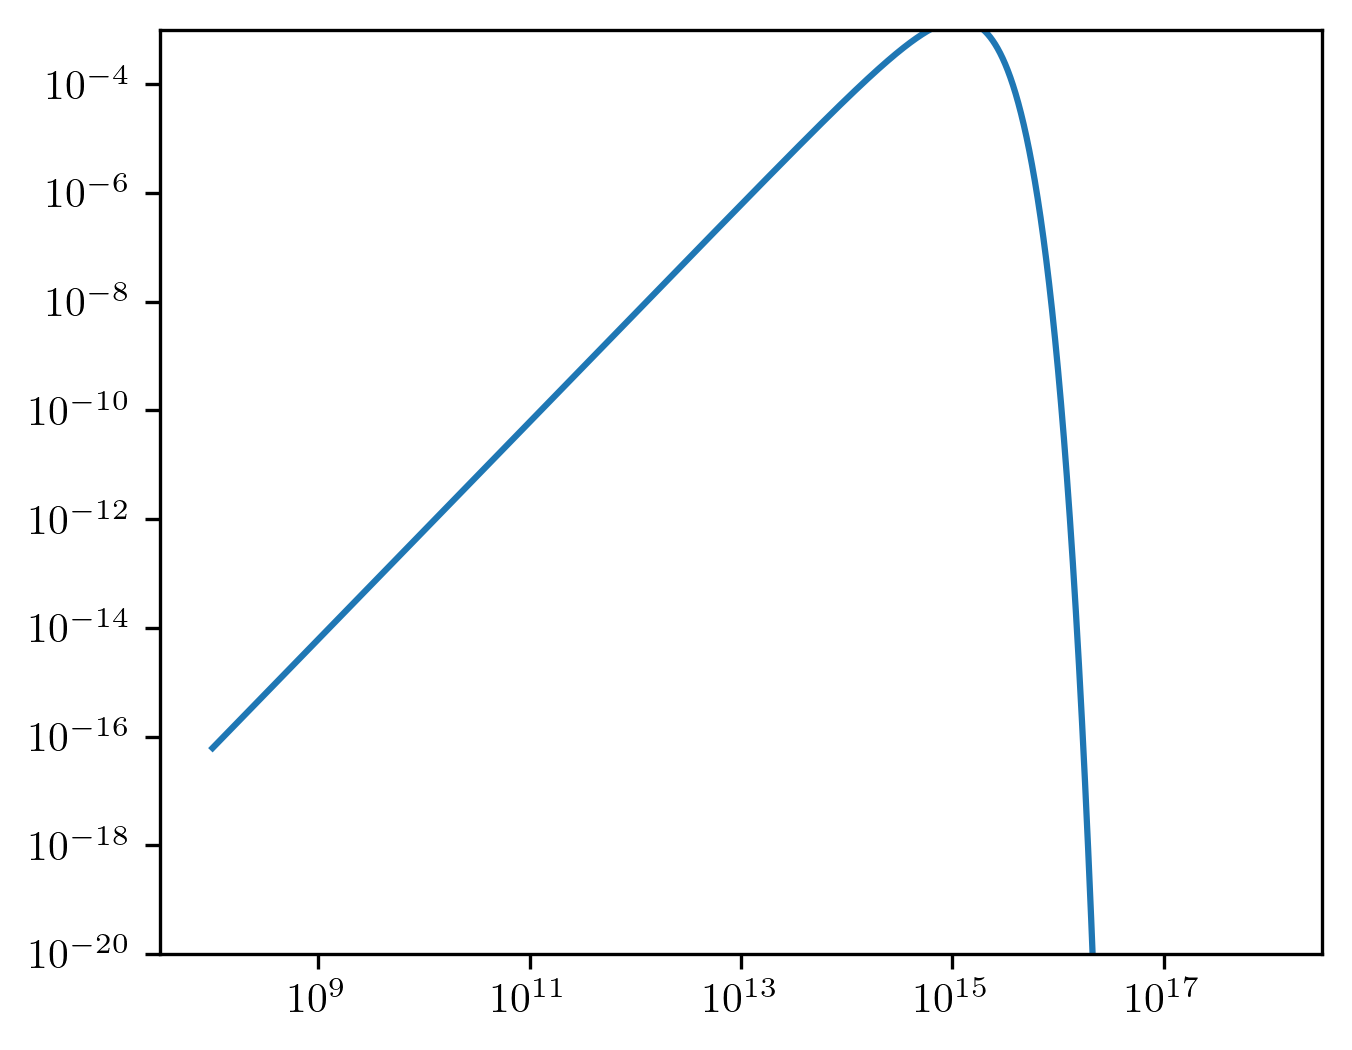

In [29]:
def planck(Temperature: float, n: float) -> float:
    """ Planck function in a cell. It needs temperature and frequency. """
    c = 2.99792458e10 #[cm/s]
    h = 6.62607015e-27 #[gcm^2/s]
    Kb = 1.380649e-16 #[gcm^2/s^2K]
    const = 2*h/c**2
    fun = const * n**3 / (np.exp(h*n/(Kb*Temperature))-1)
    print('T: ', Temperature)
    return fun

n_min = 1e8 
n_max = 1e18
n_spacing = 10000
def log_array(n_min, n_max, lenght):
    x_min = np.log10(n_min)
    x_max = np.log10(n_max)
    x_arr = np.linspace(x_min, x_max , num = lenght)
    return x_arr
x_arr = log_array(n_min, n_max, n_spacing)
n_arr = 10**x_arr

plt.plot(n_arr,planck(20000,n_arr))
plt.ylim(1e-20,1e-3)
#plt.xlim(1)
plt.loglog()


In [ ]:
def find_sphereradius():
    

In [ ]:
def flux_calculator(grad_E, idx, 
                    rays, rays_T, rays_den):
    f = np.zeros(len(grad_E))
    max_count = 0
    zero_count = 0
    flux_count = 0
    idx += 1
    for i, ray in enumerate(rays):
        # Get opacity
        Energy = ray[idx]
        max_travel = c_cgs * Energy
        
        Temperature = rays_T[i][idx]
        Density = rays_den[i][idx]
        
        # Ensure we can interpolate
        rho_low = np.exp(-22)
        T_low = np.exp(8.77)
        T_high = np.exp(17.8)
        
        # If here is nothing, light continues
        if Density < rho_low:
            zero_count += 1
            f[i] = max_travel
            continue
        
        # Stream
        if Temperature < T_low:
            continue
        
        # T too high => Thompson opacity
        if Temperature > T_high:
            print('hiiiiiiiiiii')
            Temperature = np.exp(17.7)
            
        # Get Opacity, NOTE: Breaks Numba
        k_ross = opacity(Temperature, Density, 'rosseland', ln = False)
        
        # Calc R, eq. 28
        R = np.abs(grad_E[i]) /  (k_ross * Energy)
        invR = 1 / R
        
        # Calc lambda, eq. 27
        coth = 1 / np.tanh(R)
        lamda = invR * (coth - invR)
        # Calc Flux, eq. 26
        Flux = - c_cgs * grad_E[i]  * lamda / k_ross
        
        # Choose
        if Flux > max_travel:
            f[i] = max_travel
            max_count += 1
        else:
            f[i] = Flux
            flux_count += 1
            
    print('Max: ', max_count)
    print('Zero: ', zero_count)
    print('Flux: ', flux_count)
    return f

def doer_of_thing(fix, m):
    rays_T, rays_den, rays, radii = ray_maker(fix, m)

    # NEW: Find the correct spehere radius
    if m == 4:
        if fix < 270:
            sphere_radius = 3000 
        elif np.logical_and(fix > 270, fix < 290):
            sphere_radius = 3500
        else:
            sphere_radius = 7000
    if m == 6:
        sphere_radius = 30000

    # Calculate Flux
    grad_E, idx = grad_calculator(rays, radii, sphere_radius)
    flux = flux_calculator(grad_E, idx, 
                            rays, rays_T, rays_den)

    # Divide by number of observers
    flux = np.sum(flux) / 192
    # Turn to luminosity
    sphere_radius *= Rsol_to_cm
    lum = flux * 4 * np.pi * sphere_radius**2
    print('Lum %.3e' % lum )
    return lum

In [ ]:
save = True
plot = False
m = 6 # Choose BH
fixes, days = select_fix(m)
lums = []
        
for fix in fixes:
    lum = doer_of_thing(fix, m)
    lums.append(lum)

if save:
    np.savetxt('data/reddata_m'+ str(m) + '.txt', (days, lums)) 
#%% Plotting
if plot:
    plt.figure()
    plt.plot(days, lums, '-o', color = 'maroon')
    plt.yscale('log')
    plt.ylabel('Bolometric Luminosity [erg/s]')
    plt.xlabel('Days')
    if m == 6:
        plt.title('FLD for $10^6 \quad M_\odot$')
        plt.ylim(1e41,1e45)
    if m == 4:
        plt.title('FLD for $10^4 \quad M_\odot$')
        plt.ylim(1e39,1e42)
    plt.grid()
    plt.savefig('red' + str(m) + '.png')
    plt.show()
